# SPACEc: Preprocessing - Fluorescence spillover compensation

Lateral spillover correction is a post-segmentation strategy designed to refine single-cell fluorescence measurements in densely packed tissues. In multiplexed imaging, the fluorescence from a given cell can inadvertently extend into neighboring cells—a phenomenon often described as "bleed" or "spillover." This method first quantifies the extent of shared contact between adjacent cells and then adjusts the fluorescence intensities by subtracting the estimated contaminating signal. In doing so, it reassigns the proper fluorescence to each cell, ensuring that the measured protein expression more accurately reflects each cell’s true biology.
Additionally, we have integrated PyTorch GPU support, significantly accelerating the computation process.

The pillover compensation procedure is further explained in these two publications:
1) Lee, M. Y., Bedia, J. S., Bhate, S. S., Barlow, G. L., Phillips, D., Fantl, W. J., Nolan, G. P., & Schürch, C. M. (2022). CellSeg: a robust, pre-trained nucleus segmentation and pixel quantification software for highly multiplexed fluorescence images. BMC Bioinformatics, 23(1). https://doi.org/10.1186/s12859-022-04570-9
2) Goltsev, Y., Samusik, N., Kennedy-Darling, J., Bhate, S., Hale, M., Vazquez, G., Black, S., & Nolan, G. P. (2018). Deep Profiling of Mouse Splenic Architecture with CODEX Multiplexed Imaging. Cell, 174(4), 968-981.e15. https://doi.org/10.1016/j.cell.2018.07.010

For the purpose of this tutorial we will use the output of the Cellpose segmentation (Mesmer or other results can be used as well).

The steps of the script are:

1. Loading the segmentation output 
2. Running spillover correction for multiplexed image
3. Visualize the compensation results for an example image
4. Store the data for further processing

In [1]:
# import spacec first
import spacec as sp

#import standard packages
import os
import pandas as pd
import pickle

# packages for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
# Specify the path to the data
root_path = "/home/user/path/SPACEc/" # inset your own path
data_path = root_path + 'example_data/raw/' # where the data is stored

# where you want to store the output
output_dir = root_path + 'example_data/output/'
os.makedirs(output_dir, exist_ok=True)

In [10]:
sp.hf.check_for_gpu()

GPU is available to Tensorflow
GPU is available to Pytorch


True

## Load data
Load the segmentation data (images and masks) and the dataframe with mean intensities. 

In [4]:
# Load segmentation output from pickle file
with open(output_dir + "seg_output_tonsil1_cellpose.pickle", 'rb') as f:
    seg_output1 = pickle.load(f)
    
with open(output_dir + "seg_output_tonsil2_cellpose.pickle", 'rb') as f:
    seg_output2 = pickle.load(f)

# Load dataframes with segmentation results
reg1 = pd.read_csv(output_dir + "tonsil1_cellpose_result.csv")
reg2 = pd.read_csv(output_dir + "tonsil2_cellpose_result.csv")

## Run compensation
Compensate the dataframes for both regions. Please make sure that you have enough GPU memory. Offload to system RAM makes the function run significantly slower! vRAM requirements will increase for larger images. Flushing memory between runs might help.  
NOTE: storing the compensated results as separate columns increases data size, but might be helpful to assess the effect of compensation on your dataset during later steps of the analysis. 

In [5]:
df1_c = sp.pp.compensate_cell_matrix(reg1, # dataframe with the first region
                       image_dict = seg_output1['image_dict'], # dictionary with images
                       masks = seg_output1['masks'], # masks from the second region
                       overwrite = False) # either overwrite your channels in your dataframe or add compensated channels as new columns

This function uses code from Lee, M.Y., Bedia, J.S., Bhate, S.S. et al. CellSeg: a robust, pre-trained nucleus segmentation and pixel quantification software for highly multiplexed fluorescence images. BMC Bioinformatics 23, 46 (2022) please consider citing the original work.


In [6]:
df2_c = sp.pp.compensate_cell_matrix(reg2, # dataframe with the first region
                       image_dict = seg_output2['image_dict'], # dictionary with images
                       masks = seg_output2['masks'], # masks from the second region
                       overwrite = False) # either overwrite your channels in your dataframe or add compensated channels as new columns

This function uses code from Lee, M.Y., Bedia, J.S., Bhate, S.S. et al. CellSeg: a robust, pre-trained nucleus segmentation and pixel quantification software for highly multiplexed fluorescence images. BMC Bioinformatics 23, 46 (2022) please consider citing the original work.


## Visualize compensation results

Visualze example marker in tissue.

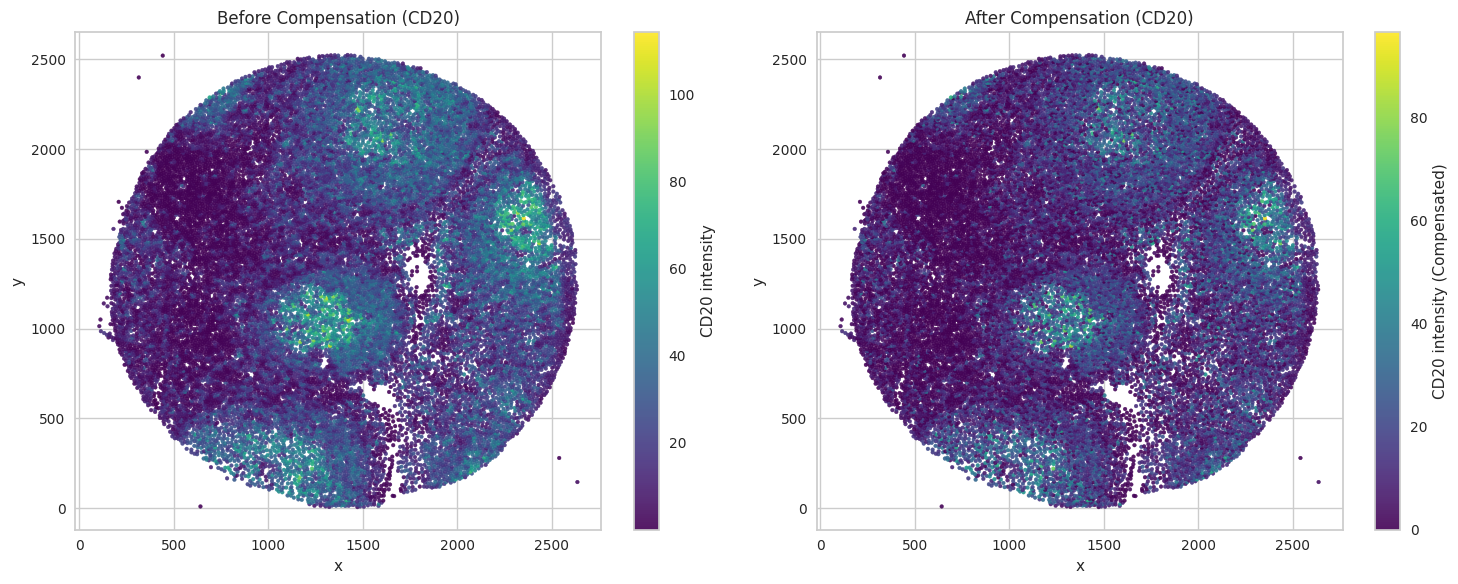

In [23]:
# Filter the DataFrame for the specified coordinate ranges.
subset = df2_c[(df2_c['x'] >= 1000) & (df2_c['x'] <= 2250) &
               (df2_c['y'] >= 1500) & (df2_c['y'] <= 2750)]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left subplot: plot with original values (CD20)
sc1 = axes[0].scatter(df2_c['x'], df2_c['y'], c=df2_c['CD20'], cmap='viridis', s=7, alpha=0.9)
axes[0].set_title("Before Compensation (CD20)")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
fig.colorbar(sc1, ax=axes[0], label="CD20 intensity")

# Right subplot: plot with compensated values (CD20_compensated)
sc2 = axes[1].scatter(df2_c['x'], df2_c['y'], c=df2_c['CD20_compensated'], cmap='viridis', s=7, alpha=0.9)
axes[1].set_title("After Compensation (CD20)")
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")
fig.colorbar(sc2, ax=axes[1], label="CD20 intensity (Compensated)")

plt.tight_layout()
plt.show()

Zoom in on an image part to inspect compensation results in more detail.

In [7]:
# Define a collection of biomarkers of interest for visualization
biomarkers_of_interest = ['CD20', 'CD3', 'FoxP3', 'HLA-DR', 'EGFR']

In [8]:
# Define the zoom-in region.
x_min, x_max = 1000, 2250
y_min, y_max = 1500, 2750
rect_width = x_max - x_min
rect_height = y_max - y_min

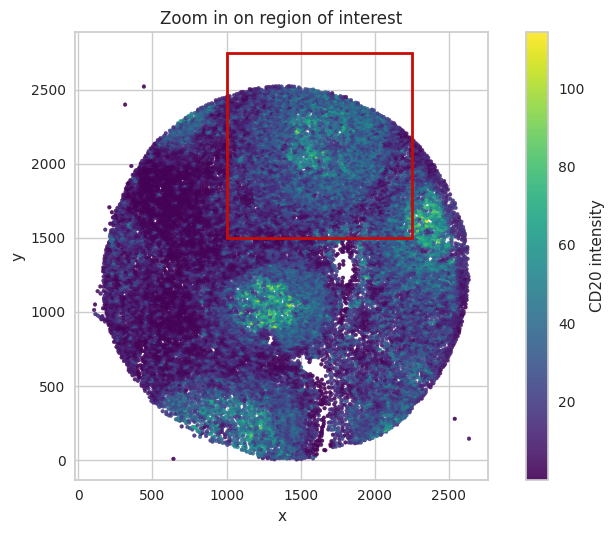

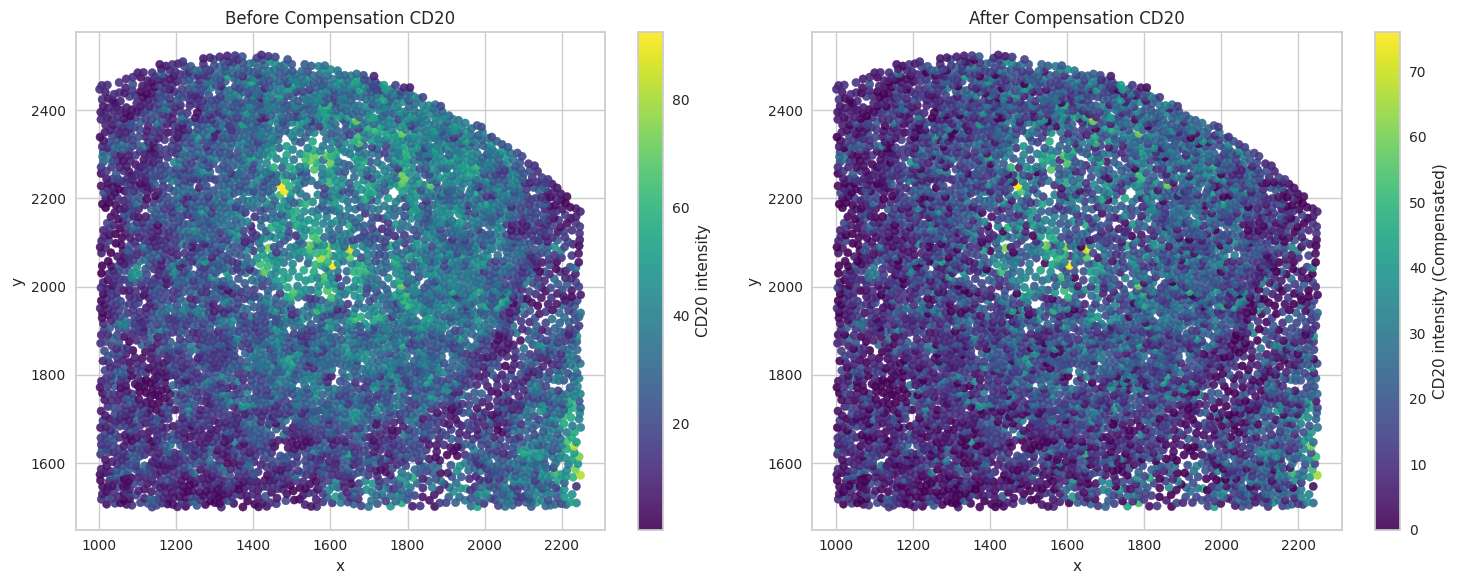

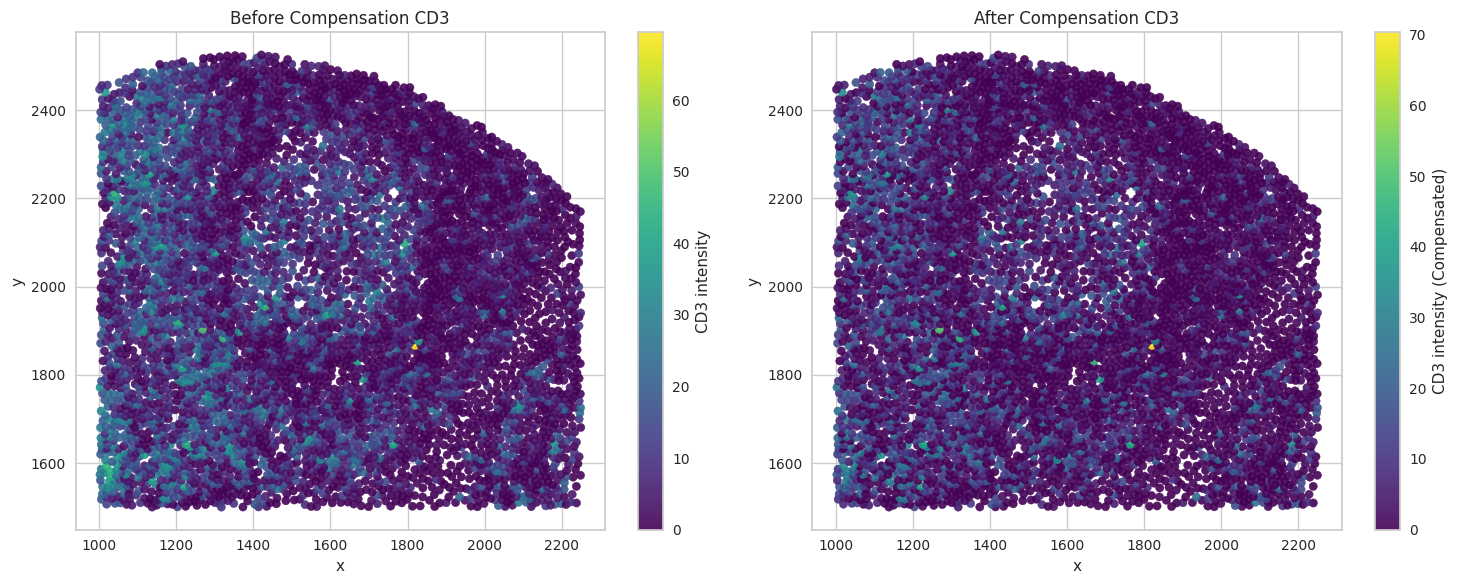

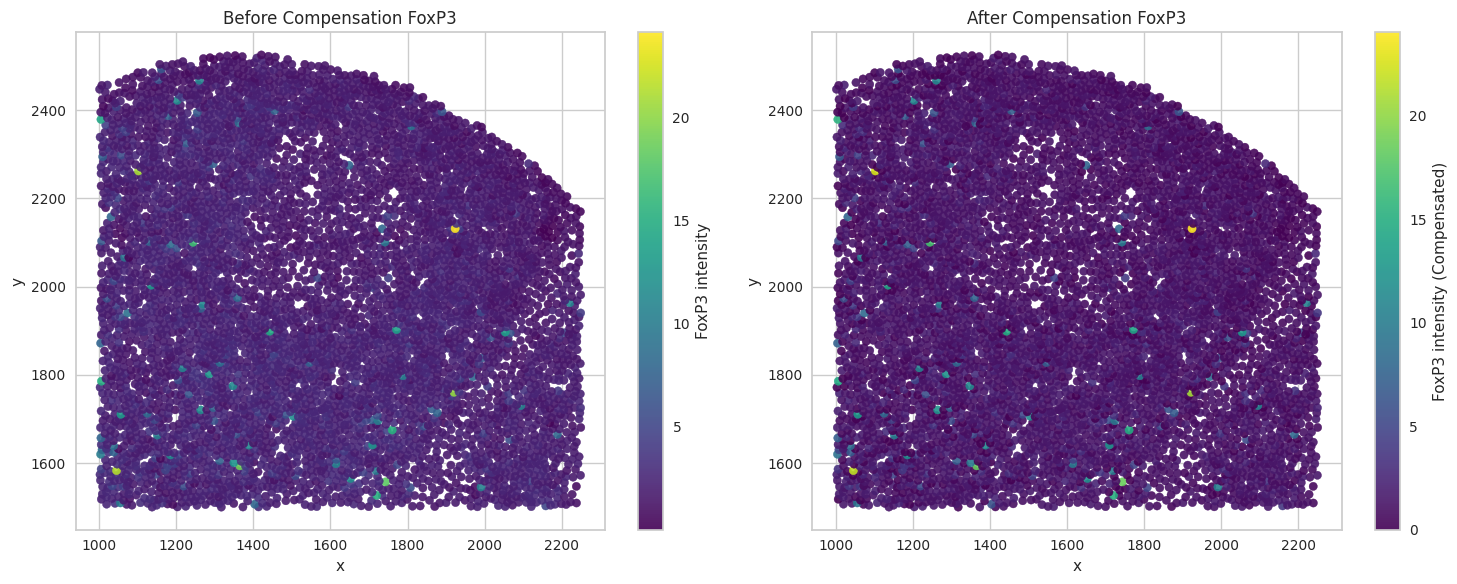

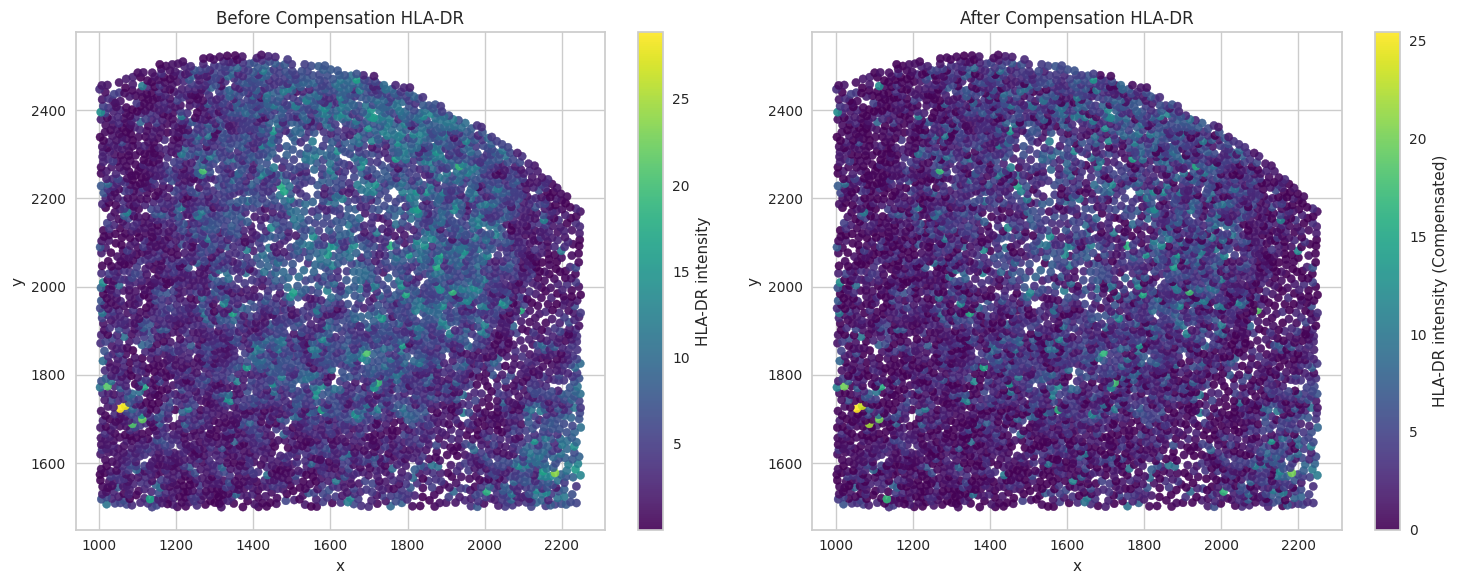

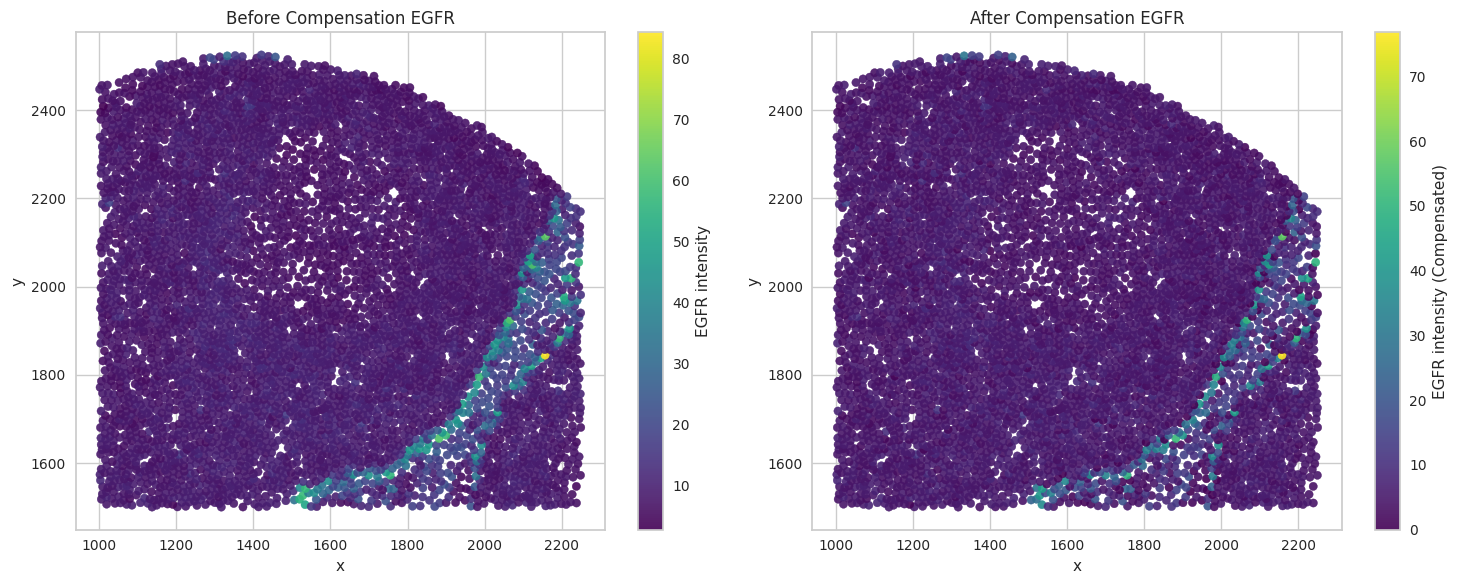

In [9]:
# Visualize the zoom-in region.
fig, ax = plt.subplots()

# Scatter plot
sc = ax.scatter(df2_c['x'], df2_c['y'], c=df2_c['CD20'], cmap='viridis', s=7, alpha=0.9)
ax.set_title("Zoom in on region of interest")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect('equal', adjustable='box')

# Add red rectangle for the zoom-in.
rect = patches.Rectangle((x_min, y_min), rect_width, rect_height,
                          linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

# Add colorbar
plt.colorbar(sc, ax=ax, label="CD20 intensity")

plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# Visualize the compensated values for the biomarkers of interest.
for marker in biomarkers_of_interest:

    # Filter the DataFrame for the specified coordinate ranges.
    subset = df2_c[(df2_c['x'] >= 1000) & (df2_c['x'] <= 2250) &
                (df2_c['y'] >= 1500) & (df2_c['y'] <= 2750)]

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Left subplot: plot with original values (CD45)
    sc1 = axes[0].scatter(subset['x'], subset['y'], c=subset[marker], cmap='viridis', s=35, alpha=0.9)
    axes[0].set_title("Before Compensation " + marker)
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")
    fig.colorbar(sc1, ax=axes[0], label=marker + " intensity")

    # Right subplot: plot with compensated values (CD20_compensated)
    sc2 = axes[1].scatter(subset['x'], subset['y'], c=subset[marker + '_compensated'], cmap='viridis', s=35, alpha=0.9)
    axes[1].set_title("After Compensation " + marker)
    axes[1].set_xlabel("x")
    axes[1].set_ylabel("y")
    fig.colorbar(sc2, ax=axes[1], label= marker + " intensity (Compensated)")

    plt.tight_layout()
    plt.show()

## Save the dataframes for further processing.

In [ ]:
df1_c.to_csv(output_dir + "tonsil1_cellpose_result_compensated.csv", index=False)
df2_c.to_csv(output_dir + "tonsil2_cellpose_result_compensated.csv", index=False)